In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

SELECTED_DIR          = os.path.join(BASE_DIR, "Selected")
CROPPED_DIR           = os.path.join(BASE_DIR, "Cropped")

os.makedirs(CROPPED_DIR, exist_ok=True)

SELECTED_CSV          = os.path.join(BASE_DIR, "selected_celeba.csv")
CROPPED_LANDMARKS_CSV = os.path.join(BASE_DIR, "cropped_landmarks_celeba.csv")

## Шаг 1

Определяем функцию, которая вырезает и ресайзит лицо из изображения, пересчитывает координаты ключевых точек лица.

Применяем эту функцию в цикле к каждому из 10 000 отобранных изображений.

Сохраняем изображения лиц в папку "Cropped", а пересчитанные координаты ключевых точек лица в cropped_landmarks_celeba.csv файл.

In [ ]:
selected_df = pd.read_csv(SELECTED_CSV)

In [ ]:
INPUT_SIZE = 256
SCALE = 1.2

In [ ]:
def crop_resize_transform(img, bbox, landmarks, output_size=INPUT_SIZE, scale=SCALE):
    """
    img: (H, W, 3)
    bbox: (x, y, w, h)
    landmarks: (5, 2) в координатах original image
    """

    H, W, _ = img.shape
    x, y, w, h = bbox

    # центр bbox
    cx = x + w / 2
    cy = y + h / 2

    # изменяем размер bbox в соответствии с параметром scale
    new_w = w * scale
    new_h = h * scale

    x1 = int(max(cx - new_w / 2, 0))
    y1 = int(max(cy - new_h / 2, 0))
    x2 = int(min(cx + new_w / 2, W))
    y2 = int(min(cy + new_h / 2, H))

    # вырезаем лицо
    face_crop = img[y1:y2, x1:x2]
    crop_h, crop_w, _ = face_crop.shape

    if crop_h == 0 or crop_w == 0:
        return None, None

    # landmarks → crop coords
    landmarks_crop = landmarks.copy()
    landmarks_crop[:, 0] -= x1
    landmarks_crop[:, 1] -= y1

    # Находим сторону максимального квадрата (чтобы не нарушать пропорции лица)
    min_size = min(crop_h, crop_w)

    # Вычисляем координаты начала (верхний левый угол)
    start_x = (crop_w - min_size) // 2
    start_y = (crop_h - min_size) // 2

    # Вырезаем центральный квадрат
    face_square = face_crop[start_y:start_y+min_size, start_x:start_x+min_size]

    # resize image
    face_resized = cv2.resize(
        face_square, (output_size, output_size),
        interpolation=cv2.INTER_LINEAR
    )

    # resize landmarks
    lm_scale = output_size / min_size

    landmarks_resized = landmarks_crop.copy()

    landmarks_resized[:, 0] -= start_x
    landmarks_resized[:, 1] -= start_y

    landmarks_resized[:, 0] *= lm_scale
    landmarks_resized[:, 1] *= lm_scale

    return face_resized, landmarks_resized

In [ ]:
records = []

for img_name in tqdm(selected_df.iloc[:, 0].values):

    image_row = selected_df[selected_df["image_id"] == img_name].iloc[0]

    img_path = os.path.join(SELECTED_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    # особенность библиотеки OpenCV, которая исторически использует порядок BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bbox = (
        image_row["x_1"],
        image_row["y_1"],
        image_row["width"],
        image_row["height"]
    )

    landmarks = np.array([
        [image_row["lefteye_x"],    image_row["lefteye_y"]],
        [image_row["righteye_x"],   image_row["righteye_y"]],
        [image_row["nose_x"],       image_row["nose_y"]],
        [image_row["leftmouth_x"],  image_row["leftmouth_y"]],
        [image_row["rightmouth_x"], image_row["rightmouth_y"]],
    ], dtype=np.float32)

    face_resized, landmarks_resized = crop_resize_transform(
        img, bbox, landmarks,
        output_size=INPUT_SIZE,
        scale=SCALE
    )

    if face_resized is None:
        continue

    # сохраняем изображение
    out_img_path = os.path.join(CROPPED_DIR, img_name)
    cv2.imwrite(
        out_img_path,
        cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR) # преобразуем в BRG
    )

    record = {
        "image_id":     img_name,
        "lefteye_x":    landmarks_resized[0, 0],
        "lefteye_y":    landmarks_resized[0, 1],
        "righteye_x":   landmarks_resized[1, 0],
        "righteye_y":   landmarks_resized[1, 1],
        "nose_x":       landmarks_resized[2, 0],
        "nose_y":       landmarks_resized[2, 1],
        "leftmouth_x":  landmarks_resized[3, 0],
        "leftmouth_y":  landmarks_resized[3, 1],
        "rightmouth_x": landmarks_resized[4, 0],
        "rightmouth_y": landmarks_resized[4, 1],
    }

    # добавляем landmarks в список
    records.append(record)

# преобразуем список в Pandas DataFrame
landmarks_df = pd.DataFrame(records)

# сохраняем DataFrame в .csv файл
landmarks_df.to_csv(CROPPED_LANDMARKS_CSV, index=False)

100%|██████████| 10000/10000 [1:01:00<00:00,  2.73it/s]


## Шаг 2

Визуально контролируем результат первого шага. Выводим случайно выбранные 5 файлов вырезанных лиц с наложенными на них ключевыми точками.

In [ ]:
lm_df = pd.read_csv(CROPPED_LANDMARKS_CSV)

In [ ]:
def visualize_sample(img_name):
    img_path = os.path.join(CROPPED_DIR, img_name)

    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read {img_name}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row = lm_df[lm_df["image_id"] == img_name]
    if len(row) == 0:
        print(f"No landmarks for {img_name}")
        return

    row = row.iloc[0]

    landmarks = [
        (row["lefteye_x"], row["lefteye_y"]),
        (row["righteye_x"], row["righteye_y"]),
        (row["nose_x"], row["nose_y"]),
        (row["leftmouth_x"], row["leftmouth_y"]),
        (row["rightmouth_x"], row["rightmouth_y"]),
    ]

    vis = img.copy()
    for (x, y) in landmarks:
        cv2.circle(vis, (int(x), int(y)), radius=3, color=(255, 0, 0), thickness=-1)

    plt.figure(figsize=(6, 6))
    plt.imshow(vis)
    plt.title(img_name)
    plt.axis("off")
    plt.show()

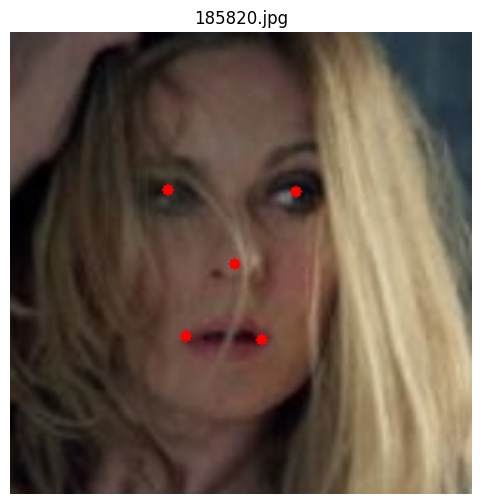

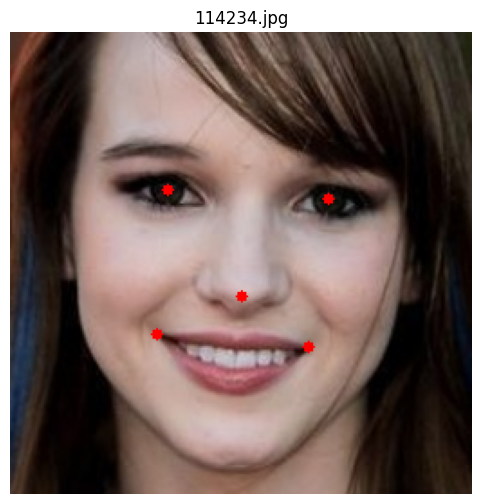

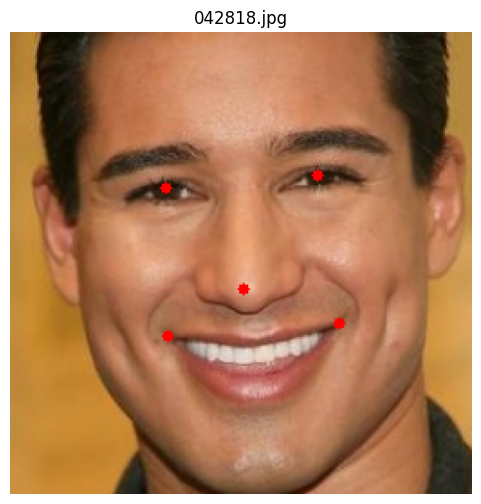

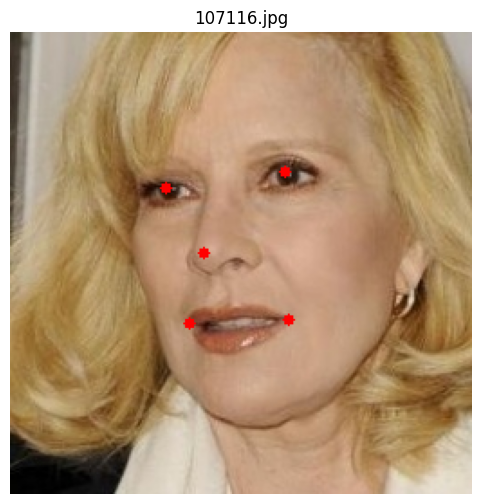

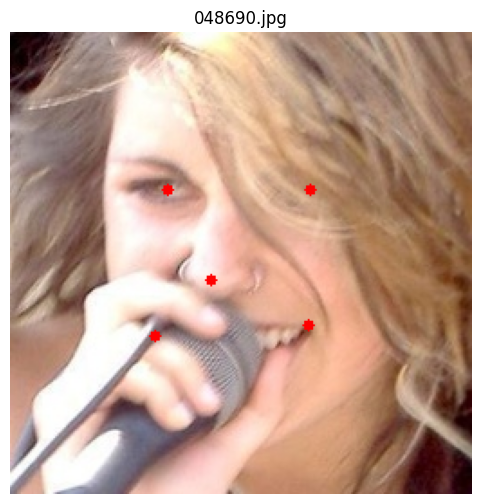

In [ ]:
N = 5

samples = random.sample(lm_df["image_id"].tolist(), N)

for img_name in samples:
    visualize_sample(img_name)